# Inputs

Имортируем необходимые библиотеки

In [30]:
import os
from dotenv import load_dotenv
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd

import random
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrConfig
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time
import numpy as np
from torch.utils.data import Dataset

import warnings
warnings.simplefilter("ignore")

Подгрузим токен для `Hugging Face`

In [2]:
load_dotenv(Path.cwd().parent / ".env")
HF_TOKEN = os.getenv("HF_TOKEN")

if HF_TOKEN is None:
    raise ValueError("HF_TOKEN not found in .env file")
else:
    print('Complete load HF_TOKEN')

Complete load HF_TOKEN


Зафиксируем `random_state` для некоторых функций

In [3]:
random.seed(42)

# Explore Models

## Utils

In [4]:
def predict_and_draw_bboxes(model, image_paths, processor):
    """
    Функция для предсказания объектов на изображениях, рисования bounding boxes с метками
    и вывода информации о предсказаниях и времени работы.
    
    Args:
        model (DetrForObjectDetection): Загруженная модель для детекции объектов.
        image_paths (list of str): Список путей к изображениям.
    """
    all_times = []  # Для хранения времени предсказания для каждого изображения
    print('\n')

    # Загрузка и обработка изображений
    for idx, image_path in enumerate(image_paths):
        # Открываем изображение
        image = Image.open(image_path)
        
        # Измеряем время предсказания
        start_time = time.time()
        
        # Применяем обработчик изображений, чтобы подготовить данные для модели
        inputs = processor(images=image, return_tensors="pt")
        
        # Прогнозируем на изображении
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Извлекаем bounding boxes и метки
        target_sizes = torch.tensor([image.size[::-1]])  # Преобразуем в (height, width)
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

        # Рисуем bounding boxes на изображении
        draw = ImageDraw.Draw(image)
        
        if len(results["boxes"]) > 0:
            print(f"[{idx}] Image: {image_path}")
            for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                # Конвертируем координаты bounding box в целочисленные значения
                xmin, ymin, xmax, ymax = box.tolist()
                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
                label_name = model.config.id2label[label.item()]
                draw.text((xmin, ymin), f"{label_name}: {score:.2f}", fill="red")
                print(f"  Label: {label_name}, Score: {score:.2f}")
        else:
            print(f"Image: {image_path}")
            print("  No objects detected. Score: nan")
        
        # Выводим время предсказания для изображения
        end_time = time.time()
        prediction_time = end_time - start_time
        all_times.append(prediction_time)
        print(f"Prediction time: {prediction_time:.4f} seconds\n")
        
        # Отображаем изображение с рамками и метками
        plt.imshow(image)
        plt.axis("off")
        plt.show()
    
    # Рассчитываем среднее время предсказания
    avg_time = np.mean(all_times)
    print(f"{'-' * 30}\n\nAverage prediction time: {avg_time:.4f} seconds")
    return {'avg_time': avg_time}

In [5]:
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = max(1e-6, (box1[2] - box1[0]) * (box1[3] - box1[1]))
    box2Area = max(1e-6, (box2[2] - box2[0]) * (box2[3] - box2[1]))
    return interArea / (box1Area + box2Area - interArea)

In [6]:
def yolo_to_xyxy(box, w, h):
    x, y, bw, bh = box
    x *= w
    y *= h
    bw *= w
    bh *= h
    return [x - bw/2, y - bh/2, x + bw/2, y + bh/2]

In [7]:
def evaluate_model_with_yolo_targets(model, processor, image_paths, label_paths, label_name_true, label_name_pred):
    iou_thresholds = [0.5, 0.8]
    ap_scores = {t: [] for t in iou_thresholds}
    total_times = []

    # Инициализируем tqdm для отображения прогресса
    for img_path, lbl_path in tqdm(zip(image_paths, label_paths), total=len(image_paths), desc="Evaluating", ncols=100):
        # Загрузка изображения
        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        # Загрузка YOLO разметки
        gt_boxes = []
        with open(lbl_path, "r") as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                cls_id = int(parts[0])
                if cls_id == label_name_true:
                    gt_boxes.append(yolo_to_xyxy(parts[1:], w, h))

        # Предсказания модели
        start_time = time.time()
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        elapsed = time.time() - start_time
        total_times.append(elapsed)

        # Постобработка результатов модели
        target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

        # Сбор предсказанных bounding box'ов
        pred_boxes = []
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            if model.config.id2label[label.item()] == label_name_pred:
                pred_boxes.append(box.tolist())

        # Подсчёт AP для каждого IoU
        for t in iou_thresholds:
            matched = set()
            tp = 0
            for gt in gt_boxes:
                for i, pred in enumerate(pred_boxes):
                    if i in matched:
                        continue
                    iou = compute_iou(gt, pred)
                    if iou >= t:
                        tp += 1
                        matched.add(i)
                        break
            precision = tp / max(1, len(pred_boxes))
            recall = tp / max(1, len(gt_boxes))
            ap = (precision + recall) / 2  # приближённая AP
            ap_scores[t].append(ap)
            # print(f"IoU@{t:.1f} — Precision: {precision:.2f}, Recall: {recall:.2f}, AP: {ap:.4f}")

    # Средние значения
    print("\n=== Итоговые результаты ===")
    metrics = {
        'average_prediction_time': np.mean(total_times),
        'average_ap_scores': {t: np.mean(ap_scores[t]) if ap_scores[t] else 0.0 for t in iou_thresholds}
    }
    
    for t in iou_thresholds:
        mean_ap = metrics['average_ap_scores'][t]
        print(f"mAP@{t}: {mean_ap:.4f}")
    
    print(f"Среднее время предсказания: {metrics['average_prediction_time']:.3f} сек")

    return metrics

In [8]:
class YOLODetectionDataset(Dataset):
    def __init__(self,
                 image_paths,
                 label_paths,
                 processor: DetrImageProcessor,
                 label_name_true: int,
                 label_name_pred: str,
                 id2label: dict):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.processor = processor
        self.label_name_true = label_name_true
        # делаем обратный словарь для поиска ID по имени
        self.id2label = id2label
        self.label2id = {v: k for k, v in id2label.items()}
        if label_name_pred not in self.label2id:
            raise ValueError(f"Unknown label_name_pred: {label_name_pred}")
        self.label_name_pred_id = self.label2id[label_name_pred]

    def __len__(self):
        return len(self.image_paths)

    def yolo_to_xyxy(self, box, w, h):
        x_c, y_c, bw, bh = box
        return [
            (x_c - bw/2) * w,
            (y_c - bh/2) * h,
            (x_c + bw/2) * w,
            (y_c + bh/2) * h,
        ]

    def __getitem__(self, idx):
        # Загружаем PIL Image и читаем YOLO-аннотации
        image = Image.open(self.image_paths[idx]).convert("RGB")
        w, h = image.size

        boxes, labels = [], []
        with open(self.label_paths[idx], "r") as f:
            for line in f:
                cls_id, x, y, bw, bh = map(float, line.strip().split())
                if int(cls_id) == self.label_name_true:
                    boxes.append(self.yolo_to_xyxy([x, y, bw, bh], w, h))
                    labels.append(self.label_name_pred_id)

        # Если нет ни одного, добавляем «фиктивный»
        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [self.label_name_pred_id]

        areas = [(x2-x1)*(y2-y1) for x1,y1,x2,y2 in boxes]
        annotations = [
            {"bbox": box, "category_id": lab, "area": area, "iscrowd": 0}
            for box, lab, area in zip(boxes, labels, areas)
        ]

        # Возвращаем сырые PIL-изображение и аннотации
        return image, {"image_id": idx, "annotations": annotations}

In [ ]:
df_results = pd.DataFrame(columns=[
    "model",
    "avg_time_predict",
    "map_0_5",
    "map_0_8",
])
results = {}
results['facebook/detr-resnet-50 (init)'] = {}
results['facebook/detr-resnet-50 (epoch 1)'] = {}

## Load Data

Установим пути к датасетам

In [45]:
# Dataset Directory
dataset_root = Path.cwd().parent / "data" / "final_dataset"

# Test Dataset
test_images_dir = dataset_root / "images" / "test"
test_labels_dir = dataset_root / "labels" / "test"

# Train Dataset
train_images_dir = dataset_root / "images" / "train"
train_labels_dir = dataset_root / "labels" / "train"

# Validation Dataset
val_images_dir = dataset_root / "images" / "val"
val_labels_dir = dataset_root / "labels" / "val"

# Paths to images
test_image_paths = list(test_images_dir.glob("*.png"))[:20]
train_image_paths = list(train_images_dir.glob("*.png"))[:20]
val_image_paths = list(val_images_dir.glob("*.png"))[:20]

# Paths to images
test_label_paths = list(test_labels_dir.glob("*.txt"))[:20]
train_label_paths = list(train_labels_dir.glob("*.txt"))[:20]
val_label_paths = list(val_labels_dir.glob("*.txt"))[:20]

## Model 1: facebook/detr-resnet-50

### Init

Посмотрим на пример предсказания данной модели

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\101_orig.png
  No objects detected. Score: nan
Prediction time: 1.1095 seconds



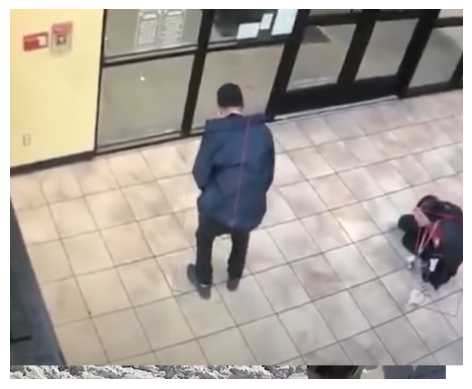

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\100_orig.png
  No objects detected. Score: nan
Prediction time: 0.8916 seconds



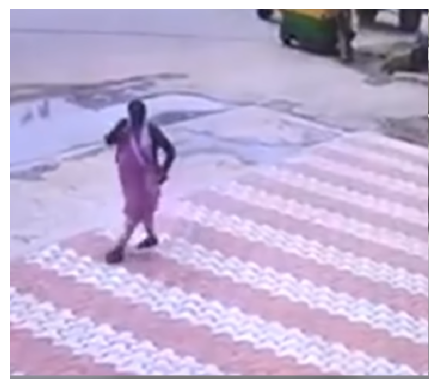

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\11_aug3.png
  No objects detected. Score: nan
Prediction time: 0.7986 seconds



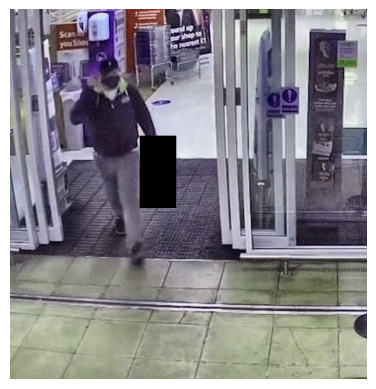

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\100_aug5.png
  No objects detected. Score: nan
Prediction time: 0.8456 seconds



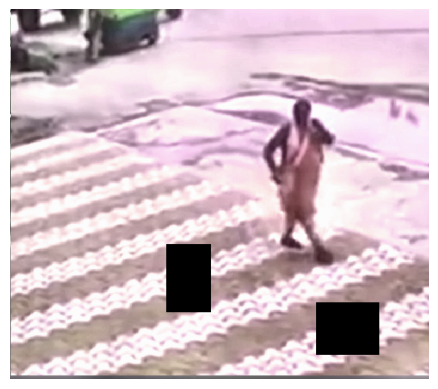

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\111_aug4.png
  No objects detected. Score: nan
Prediction time: 1.0819 seconds



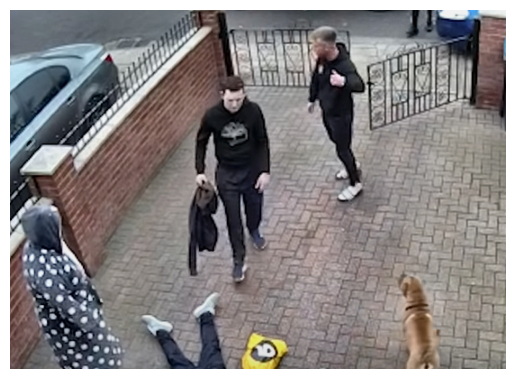

------------------------------

Average prediction time: 0.9455 seconds


In [52]:
# Импортируем модель
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name, token=HF_TOKEN)
model = DetrForObjectDetection.from_pretrained(model_name,  token=HF_TOKEN)

# Заменяем классификатор вручную
model.class_labels_classifier = torch.nn.Linear(in_features=model.class_labels_classifier.in_features, out_features=2)

# Обновляем конфиг вручную
model.config.num_labels = 1
model.config.id2label = {0: "person"}
model.config.label2id = {"person": 0}

# Выберем картинки
image_paths = random.sample(test_image_paths, 5)
label_paths = [Path(str(path).replace('images', 'labels').replace('.png', '.txt')) for path in image_paths]

# Вызов функции для предсказания и отображения изображений с bounding boxes
results['facebook/detr-resnet-50 (init)']['avg_time_predict'] = predict_and_draw_bboxes(model, image_paths, processor)['avg_time']

In [12]:
image_paths = random.sample(test_image_paths, len(test_image_paths))
label_paths = [Path(str(path).replace('images', 'labels').replace('.png', '.txt')) for path in image_paths]

results['facebook/detr-resnet-50 (init)']['metrics'] = evaluate_model_with_yolo_targets(
    model=model,
    processor=processor,
    image_paths=image_paths,
    label_paths=label_paths,
    label_name_true=0,        # В YOLO аннотации класс "person" — это 0
    label_name_pred="person" # В модели HF класс называется 'person'
)['average_ap_scores']

Evaluating:   0%|                                                           | 0/504 [00:00<?, ?it/s]


=== Итоговые результаты ===
mAP@0.5: 0.7943
mAP@0.8: 0.7045
Среднее время предсказания: 0.732 сек


### Train

In [53]:
def collate_fn(batch):
    images, annots = zip(*batch)  # распаковываем список кортежей
    # Processor сам сделает resize, normalize и паддинг
    batch_enc = processor(
        images=list(images),
        annotations=list(annots),
        return_tensors="pt"
    )
    return batch_enc

In [54]:
id2label = model.config.id2label  # например: {0: 'class_0', 1: 'class_1', ..., 91: 'person'}

# Создаём train и val датасеты
label_name_true = 0           # класс "person" в YOLO-данных
label_name_pred = 'person'    # название "person" в модели DETR

train_dataset = YOLODetectionDataset(
    image_paths=train_image_paths,
    label_paths=train_label_paths,
    processor=processor,
    label_name_true=0,
    label_name_pred='person',
    id2label=id2label
)

val_dataset = YOLODetectionDataset(
    image_paths=val_image_paths,
    label_paths=val_label_paths,
    processor=processor,
    label_name_true=0,
    label_name_pred='person',
    id2label=id2label
)

In [55]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./saves-2/facebook/detr-resnet-50",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    save_steps=500,
    eval_strategy="epoch",
    logging_dir="./saves-2/facebook/detr-resnet-50/logs",
    remove_unused_columns=False,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    tokenizer=processor,
)

In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,3.449429
2,No log,3.120515
3,No log,2.874785
4,No log,2.772057
5,No log,2.649652


TrainOutput(global_step=15, training_loss=2.707885487874349, metrics={'train_runtime': 78.1029, 'train_samples_per_second': 1.28, 'train_steps_per_second': 0.192, 'total_flos': 5.858885882998368e+16, 'train_loss': 2.707885487874349, 'epoch': 5.0})



Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\100_orig.png
  No objects detected. Score: nan
Prediction time: 0.8658 seconds



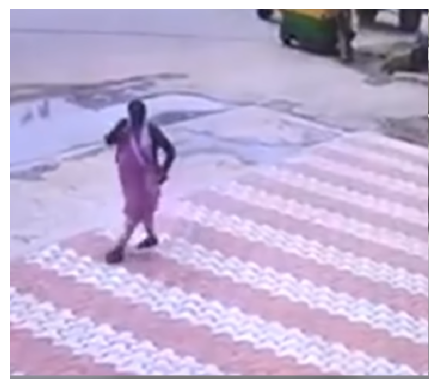

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\0_aug4.png
  No objects detected. Score: nan
Prediction time: 0.7769 seconds



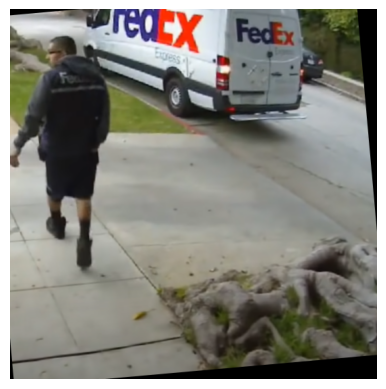

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\105_aug5.png
  No objects detected. Score: nan
Prediction time: 0.8021 seconds



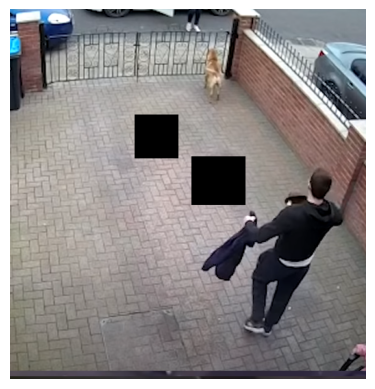

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\104_orig.png
  No objects detected. Score: nan
Prediction time: 0.8136 seconds



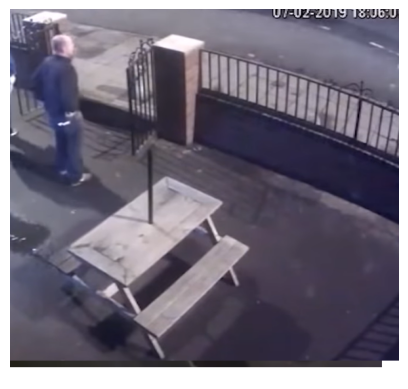

Image: d:\Documents\ITMO\Semestr_2\dl_in_practice\people-detection\data\final_dataset\images\test\119_aug5.png
  No objects detected. Score: nan
Prediction time: 0.8113 seconds



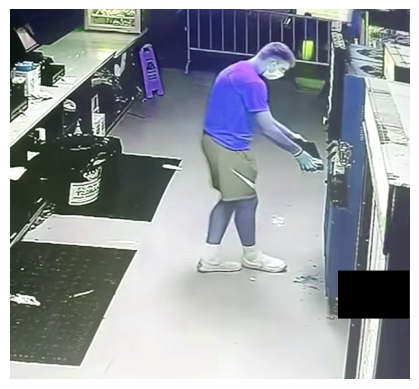

------------------------------

Average prediction time: 0.8140 seconds


In [57]:
# Импортируем модель
model_name = "./saves-2/facebook/detr-resnet-50/checkpoint-15"
processor = DetrImageProcessor.from_pretrained(model_name, token=HF_TOKEN)
model = DetrForObjectDetection.from_pretrained(model_name, token=HF_TOKEN)

# Выберем картинки
image_paths = random.sample(test_image_paths, 5)
label_paths = [Path(str(path).replace('images', 'labels').replace('.png', '.txt')) for path in image_paths]

# Вызов функции для предсказания и отображения изображений с bounding boxes
results['facebook/detr-resnet-50 (epoch 1)']['avg_time_predict'] = predict_and_draw_bboxes(model, image_paths, processor)['avg_time']

In [21]:
image_paths = random.sample(test_image_paths, len(test_image_paths))
label_paths = [Path(str(path).replace('images', 'labels').replace('.png', '.txt')) for path in image_paths]

results['facebook/detr-resnet-50 (epoch 1)']['metrics'] = evaluate_model_with_yolo_targets(
    model=model,
    processor=processor,
    image_paths=image_paths,
    label_paths=label_paths,
    label_name_true=0,        # В YOLO аннотации класс "person" — это 0
    label_name_pred="person" # В модели HF класс называется 'person'
)['average_ap_scores']

Evaluating:   0%|                                                           | 0/504 [00:00<?, ?it/s]


=== Итоговые результаты ===
mAP@0.5: 0.3185
mAP@0.8: 0.0306
Среднее время предсказания: 0.827 сек
